<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AALU_Coding/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec Application Tutorial
In this tutorial, we go over basic operations on word vectors. There are many Natural Language Processing (NLP) libraries in Python, such as [NLTK](https://www.nltk.org/), [gensim](https://radimrehurek.com/gensim/), and [spaCy](https://spacy.io/). All of them have their own strength and focus. NLTK is one of the first comprehensive Python libraries for computational linguistics and has a big community. If you have worked on NLP, you probably have heard of it or used it. Gensim is a popular library for topic modeling. It also provides many functionalities similar to NLTK. It supports word embeddings and you can even train word embeddings using gensim. SpaCy is another popular NLP library and it provides built-in support for word vectors. We will use spaCy in this tutorial.  \\
<br>
You will learn:


1.   Popular Python machine learning packages (spaCy, sklearn)
2.   Calculating word similarity using Word2Vec model
3.   Word analogy analysis
4.   Calculating sentence similarity using Word2Vec model
5.   Dimension reduction techniques for high-dimensional vectors
6.   Visualizing Word2Vec in 2D space
7.   Sentiment analysis using logistic regression and Word2Vec



### Preliminary
First, let's install the spaCy Python library and download their model for the English language. We only need to do it once. Then we can import the spaCy library and other useful libraries such as numpy (used for linear algebra and vector operations in Python). We can load our downloaded English model in our environment.

In [ ]:
# Only needs to be run once at the top of the notebook
!pip install spacy
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 6.8 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# import packages
import spacy
import numpy as np
import csv
from sklearn.manifold import TSNE
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
nlp = spacy.load('en_core_web_lg')  # load the English model

### Word Similarity
By representing words in vectors, we can use linear algebra and vector space models to analyze the relationship between words. One simple task is to calculate the cosine of two word vectors, namely the cosine similarity. This cosine similarity measures the semantic similarity of words. While the value ranges from -1 to 1, it is usually used in the non-negative space [0, 1] where 0 means 0 similarity and 1 means extremely similar or even identical.

In order to calculate the cosine similarity between words, we have to know their vector representations first, which are provided by the Word2Vec model. In the spaCy English model, these vector representations (pretrained using Word2Vec) are already provided. All we need to do is to retrieve these words from the spaCy English model and we will have access to these vector representations. \\
<br>
![cosine_sim](https://engineering.aweber.com/wp-content/uploads/2013/02/4AUbj.png)

In [ ]:
# retrieve words from the English model vocabulary
rationalism = nlp.vocab['rationalism']
rationality = nlp.vocab['rationality']

# print the dimension of word vectors
print('vector length:', len(rationality.vector))

# print the word vector
print('rationality:', rationality.vector)

Try to retrieve some other words and check if they have the same dimension.

In [ ]:
# try your own words and check if they have the same dimension of the cat vector
############# YOUR CODE HERE ################
computer = nlp.vocab['computer']

print(len(computer.vector))

300


After retrieving the words and their vector representations, we can use the built-in similarity function (which implements cosine similarity) to calculate word similarity based on these vectors. Is 'cat' more similar to 'dog' than 'car'? Can you find some properties of cosine similarity?

In [ ]:
# you can calculate the similarity between words using
# the built-in 'similarity' function
print('The similarity between cat and cat:', cat.similarity(cat))
print('The similarity between cat and dog:', cat.similarity(dog))
print('The similarity between dog and cat:', dog.similarity(cat))
print('The similarity between cat and car:', cat.similarity(car))
print('The similarity between dog and car:', dog.similarity(car))

The similarity between cat and cat: 1.0
The similarity between cat and dog: 0.8220816850662231
The similarity between dog and cat: 0.8220816850662231
The similarity between cat and car: 0.19698593020439148
The similarity between dog and car: 0.3250025510787964


Now let's try some other words. Also, try to calculate the cosine similarity between 'hotel' and 'motel' and the cosine similarity between 'hotel' and 'hospital'. Which one is more similar to 'hotel'? 'motel' or 'hospital'?

In [ ]:
# calculate the similarity of your own words using the built-in function
############# YOUR CODE HERE ################
hotel = nlp.vocab['hotel']
motel = nlp.vocab['motel']
hospital = nlp.vocab['hospital']

# what is the similarity between (hotel, motel) and (hotel, hospital)
############# YOUR CODE HERE ################
print(hotel.similarity(motel))

print(hotel.similarity(hospital))


0.7972079515457153
0.42509356141090393


Let's compute the cosine similarity manually using its definition below. Then check if the result is the same as the one calculated by the built-in function. \\
<br>
$cosine\_similarity(A, B) = \frac{A \cdot B}{\left \| A \right \|\left \| B \right \|}$

In [ ]:
# try to calculate cosine similarity manually
'''
cosine of V1 and V2 = dot product of V1 and V2 / product of V1 norm and V2 norm
To get the vector representation of a word, use .vector, e.g. car.vector
To calculate the dot product of two vectors V1 and V2, use np.dot(V1, V2)
To get the norm of a word vector, use .vector_norm, e.g. car.vector_norm,
alternatively you can use np.linalg.norm(V1) to calculate the norm of V1
'''
############# YOUR CODE HERE ################
cosine_dog_car = np.dot(dog.vector, car.vector)/(dog.vector_norm*car.vector_norm)
print('The similarity between dog and car calculated manually:', cosine_dog_car)
#############################################

The similarity between dog and car calculated manually: 0.32500255


Now we know how to compare the similarity of two words using pretrained Word2Vec model. We can also use it to help us find semantically similar words, that is given a word retrieve similar words from the vocabulary. \\
<br>
The Python spaCy library hasn't provided such a function to do precisely this yet. We could use other NLP and machine learning libraries, such as [gensim](https://radimrehurek.com/gensim/), to do this with a simple function call. But the implementation is not hard, so let's give it a try! In our customized function, we first find all the words in our vocabulary (that has vector representations). Then we calculate the cosine similarity between our query word and each word in the vocabulary. We sort the similarity score in descending order. Finally, we retrieve the top n most similar words.

In [ ]:
# function to find similar words
def most_similar(word, topn=10):
    allwords = [w for w in nlp.vocab if w.has_vector and w.is_lower and w.lower_ != word.lower_]  # get all words in the vocabulary
    by_similarity = sorted(allwords, key=lambda w: word.similarity(w), reverse=True)  # sort words by similarity in descending order
    return by_similarity[:topn]

In [ ]:
# find similar words
cat_similar = [w.text for w in most_similar(dog)]
print('Similar words to cat: ', cat_similar)

Similar words to cat:  ['cat', 'you', 'car', 'somethin’', 'lovin’', "'cause", 'lovin', 'she', "somethin'", 'it']


### Word Analogy
One interesting finding for the Word2Vec model is that it embeds some analogical relationships between words. \\
<br>
*Man is to Woman as King is to Queen* \\
Man - Woman = King - Queen \\
<br>
*Paris is to France as Madrid is to Spain* \\
Paris - France = Madrid - Spain \\
<br>
These relationships can be reconstructed using word embeddings. \\
<br>
![analogy](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

In [ ]:
# word analogy example
# king is to man as what is to woman?
king = nlp.vocab['king']
man = nlp.vocab['man']
woman = nlp.vocab['woman']

# resulting vector
result = king.vector - man.vector + woman.vector

# function to compute cosine similarity
cosine = lambda v1, v2: np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
# what word does the 'result' vector closely correspond to?

# we can first check if the 'result' vector is similar to the 'queen' vector
############# YOUR CODE HERE ################
queen = nlp.vocab['queen']
print('Similarity between queen and result:', cosine(result, queen.vector))
#############################################

# find all words in our vocabulary (nlp.vocab),
# make sure to just retrieve lower case words
# and words that actually have vectors (.has_vector)
# and filter out 'king', 'man', and 'woman'
############# YOUR CODE HERE ################
allwords = [w for w in nlp.vocab if w.has_vector and w.is_lower and w.lower_ != 'king' and w.lower_ != 'man' and w.lower_ != 'woman']
#############################################

# calculate the cosine similarity between the 'result' vector
# and all word vectors in our vocabulary
# sort by similarity and print out the most similar one
############# YOUR CODE HERE ################
candidates = sorted(allwords, key=lambda w: cosine(result, w.vector), reverse=True)
print([c.text for c in candidates[:5]])

Similarity between queen and result: 0.6178015
['queen', 'and', 'that', 'r.', 'where']


Let's try: \\
Paris - France = Madrid - Spain

In [ ]:
# another example
# Paris is to France as Madrid is to what?
############# YOUR CODE HERE ################
Paris = nlp.vocab['Paris']
France = nlp.vocab['France']
Madrid = nlp.vocab['Madrid']

maybe_Spain = France.vector - Paris.vector + Madrid.vector

allwords = [w for w in nlp.vocab if w.has_vector and w.lower_ != 'paris' and w.lower_ != 'madrid' and w.lower_ != 'france']
candidates = sorted(allwords, key=lambda w: cosine(maybe_Spain, w.vector), reverse=True)
print([c.text for c in candidates[:5]])
#############################################

['and', 'king', 'Colo', 'Calif', 'were']


### Sentence/Document Level Similarity
Using word embeddings, we can also calculate similarity between sentences and documents. More advanced models such as Doc2Vec or neural networks can be used, but in this tutorial we will continue to use Word2Vec model to calculate document similarity. Since sentences and documents are composed of words, one easy way to obtain vector representations for sentences/documents is to calculate the average vectors of words. \\
<br>
Let's try to calculate the similarity among these three sentences:


1.   Cats are beautiful animals.
2.   Some gorgeous creatures are felines.
3.   Dolphins are swimming mammals.



In [ ]:
# Word2Vec model does not provide vector representations for sentences
# or documents. How is the similarity between sentences computed?
# Since sentences are composed of words, an easy way to obtain the vector
# representations of sentences is by averaging the vectors of each word in
# the sentence.
############# YOUR CODE HERE ################
s1 = (nlp.vocab['Cats'].vector + nlp.vocab['are'].vector + nlp.vocab['beautiful'].vector + \
    nlp.vocab['animals'].vector + nlp.vocab['.'].vector)/5
s2 = (nlp.vocab['Some'].vector + nlp.vocab['gorgeous'].vector + nlp.vocab['creatures'].vector + \
    nlp.vocab['are'].vector + nlp.vocab['felines'].vector + nlp.vocab['.'].vector)/6
s3 = (nlp.vocab['Dolphins'].vector + nlp.vocab['are'].vector + nlp.vocab['swimming'].vector + \
    nlp.vocab['mammals'].vector + nlp.vocab['.'].vector)/5

print(cosine(s1, s2))

print(cosine(s1, s3))



0.90675163
0.9037428


In [ ]:
# spaCy also supports similarity calculation between sentences and documents
target = nlp("Cats are beautiful animals.")  # text about cats

doc1 = nlp("Some gorgeous creatures are felines.")  # text about cats
doc2 = nlp("Dolphins are swimming mammals.")  # text about dolphins

print('Similarity between target and doc1:', target.similarity(doc1))
print('Similarity between target and doc1:', target.similarity(doc2))

Similarity between target and doc1: 0.9067517259890845
Similarity between target and doc1: 0.9037427153904276


### Word Embeddings Visualization
Since the word vectors we use have 300 dimensions, we cannot visualize them. One natural way is to apply dimension reduction first and then visualize them. We use a popular dimension reduction technique called [t-SNE](https://lvdmaaten.github.io/tsne/) (you can also use PCA) to reduce the word vectors to 2D and then plot the words in our word analogy example to see if we can find some pattern visually. \\
<br>
An interactive visualization of word embeddings can be found here: \\
[https://projector.tensorflow.org/](https://projector.tensorflow.org/)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


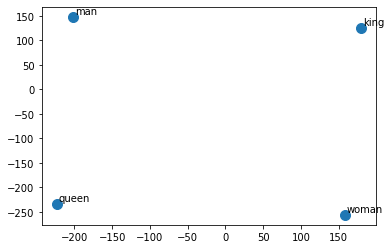

In [ ]:
# use t-SNE to do dimension reduction, from 300d to 2d
tsne_model = TSNE(n_components=2)

# get transformed vectors
data = np.array([king.vector, man.vector, queen.vector, woman.vector])
data_2d = tsne_model.fit_transform(data)

labels = ['king', 'man', 'queen', 'woman']

# plot the 2d vectors and show their labels
plt.scatter(data_2d[:, 0], data_2d[:, 1], s=100)
for i, txt in enumerate(labels):
    plt.annotate(txt, (data_2d[i,0], data_2d[i,1]), xytext=(2, 3), textcoords='offset points')
plt.show()

### Sentiment Analysis
The major reason for coming up with word embedding models is that we want to use these embeddings which encode the word semantics to help us tackle problems related with natural language. \\
<br>
One such task is sentiment analysis. By analyzing the sentiment of texts, we want to understand whether a given sentence/document is positive or negative. For example, 'the weather is so nice today' has a positive sentiment whereas 'he is bored by the movie' has a negative sentiment. \\
<br>
In this tutorial, we want to use the word embeddings combined with a simple machine learning model ([logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) to do sentiment analysis. Logistic regression is a linear classification model and in our case we want to classify whether a given sentence is positive or negative. So it's a binary classification. \\
<br>
![logistic](https://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression_files/logistic_regression_schematic.png)
<br>
Our training data contains 2,748 from Yelp reviews, IMDB movie reviews, and Amazon reviews. In the dataset, 1 means positive and 0 means negative. The original data can be downloaded from [here](https://www.kaggle.com/rahulin05/sentiment-labelled-sentences-data-set/data), the combined file can be downloaded from [here](https://drive.google.com/file/d/1knrjvDNkiXtviXBoLm5OJY45_kcCmDxe/view?usp=sharing).

In [ ]:
# load files into the environment
from google.colab import files
uploaded = files.upload()

In [ ]:
# read data
data_raw = []
with open('combined_training.txt', newline='') as fr: #combined_training.txt
    reader = csv.reader(fr, delimiter='\t')
    for row in reader:
        data_raw.append([row[0], int(row[1])])

# print the number of data
print(len(data_raw))

# print the last data item
print(data_raw[-1])

In [ ]:
x_train = np.array([nlp(d[0]).vector for d in data_raw])
y_train = np.array([d[1] for d in data_raw])

# print the dimension of x
print(x_train.shape)

# print the dimension of y
print(y_train.shape)

# double check
print(nlp(data_raw[-1][0]).text, y_train[-1])

In [ ]:
logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)

In [ ]:
# predict using trained model
predict = logreg.predict(np.array([nlp('the weather today is pleasant').vector, nlp('the food in this restaurant is beyond my expectation').vector]))
print(predict)